# MINE4201- SR -  Laboratorio 1 
# Exploración modelos KNN



Vamos a utilizar las siguientes librerias en el laboratorio


In [140]:
!pip install "numpy>=1.25.0,<2.0.0"
!pip install scikit-surprise
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip


In [141]:
import os
import numpy as np
import pandas as pd
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import train_test_split
from surprise import KNNBasic
from surprise import accuracy
import random
import matplotlib.pyplot as plt

#Para garantizar reproducibilidad en resultados
seed = 10
random.seed(seed)
np.random.seed(seed)


## Suba al servidor los archivos u.data y u.item que se encuentran en el dataset descargado, en la pestaña files

In [142]:
if not (os.path.exists('./u.data') and os.path.exists('./u.item')):
  raise ValueError('Los archivos u.data e u.item no fueron encontrados en el path')
else:
  print("Los archivos han sido cargados")

Los archivos han sido cargados


In [143]:
ratings=pd.read_csv('./u.data', sep = '\t', names = [ 'user_id', 'item_id', 'rating', 'timestamp' ] )

In [144]:
items=pd.read_csv('./u.item', sep = '\|', names = ['movie id' ,'movie title','release date','video release date','IMDb URL ','unknown',
                                                          'Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama',
                                                          'Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western'], encoding='latin-1', engine='python' )

Verifique que los ratings y los items hayan sido cargados correctamente





In [145]:
#ratings.rating=ratings.rating.astype('category')
ratings.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [146]:
items.head()

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Visualice la distribución de ratings, ¿Qué puede decir al respecto?

Se observa un sesgo hacia valores medios/altos (típicamente 3 y 4), lo que indica que la mayoría de usuarios tiende a evaluar de forma positiva. Los porcentajes sobre cada barra cuantifican esta concentración y dejan ver que los extremos (1 y 5) son menos frecuentes. Esto sugiere que el dataset no es balanceado en ratings.

- Puede ocurrir que el modelo tienda a predecir ratings altos con mayor frecuencia, lo que podría afectar la precisión de las recomendaciones.

- Además, la concentración en ratings medios/altos puede dificultar la diferenciación entre items, ya que muchos podrían tener calificaciones similares, lo que podría llevar a recomendaciones menos personalizadas y más genéricas.

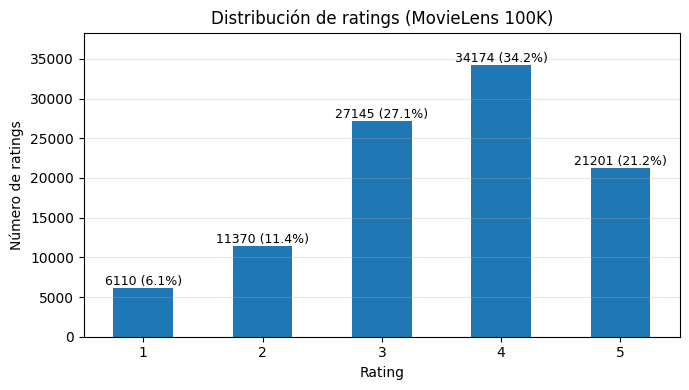

In [147]:
# Count how many ratings of each value (1..5) exist
counts = (
    ratings["rating"]
    .value_counts()
    .reindex(range(1, 6), fill_value=0)  # ensure we always have bars for 1..5
    .astype(int)
)

# Convert counts to percentages
perc = counts / counts.sum() * 100

# Create a bar chart from the counts
ax = counts.plot(kind="bar", figsize=(7, 4), rot=0)

# Basic formatting
ax.set(
    title="Distribución de ratings (MovieLens 100K)",
    xlabel="Rating",
    ylabel="Número de ratings",
)
ax.grid(axis="y", alpha=0.3)

# Add a little headroom so labels don't touch the top border
top = counts.max()
ax.set_ylim(0, top * 1.12)  # 12% extra space (adjust if you want more/less)

# Annotate each bar with "count (percent%)"
for i, v in enumerate(counts):
    ax.text(
        i, v,                          # x position (bar index), y position (bar height)
        f"{v} ({perc.iloc[i]:.1f}%)",   # label text
        ha="center",
        va="bottom",
        fontsize=9,
    )

plt.tight_layout()
plt.show()

## En la siguiente celda se esta calculando el número de ratings por usuario y el promedio de sus calificaciones, el dataframe esta ordenado por el número de calificaciones

In [148]:
ratings.groupby('user_id')['rating'].agg(['count','mean']).sort_values('count', ascending=False)

,count,mean
user_id,,
405,737,1.834464
655,685,2.908029
13,636,3.097484
450,540,3.864815
276,518,3.465251
...,...,...
685,20,2.050000
475,20,3.600000
36,20,3.800000


In [149]:
ratings.groupby('user_id')['rating'].mean().reset_index()

,user_id,rating
0,1,3.610294
1,2,3.709677
2,3,2.796296
3,4,4.333333
4,5,2.874286
...,...,...
938,939,4.265306
939,940,3.457944
940,941,4.045455
941,942,4.265823


## Utilice las siguientes celdas para encontrar respuesta a las siguientes preguntas

¿Cómo es la distribución del número de ratings por usuario?

¿Cómo es la distribución del promedio de calificación por usuario?


### ¿Cómo es la distribución del número de ratings por usuario?

La mayoría de usuarios tienen pocos ratings, y unos pocos usuarios tienen muchísimos.
Hay usuarios más generosos, pero pocos: la mayoría está en un rango razonable.
No hay una relación fuerte entre “cuántas películas califica” y “qué tan alto califica”


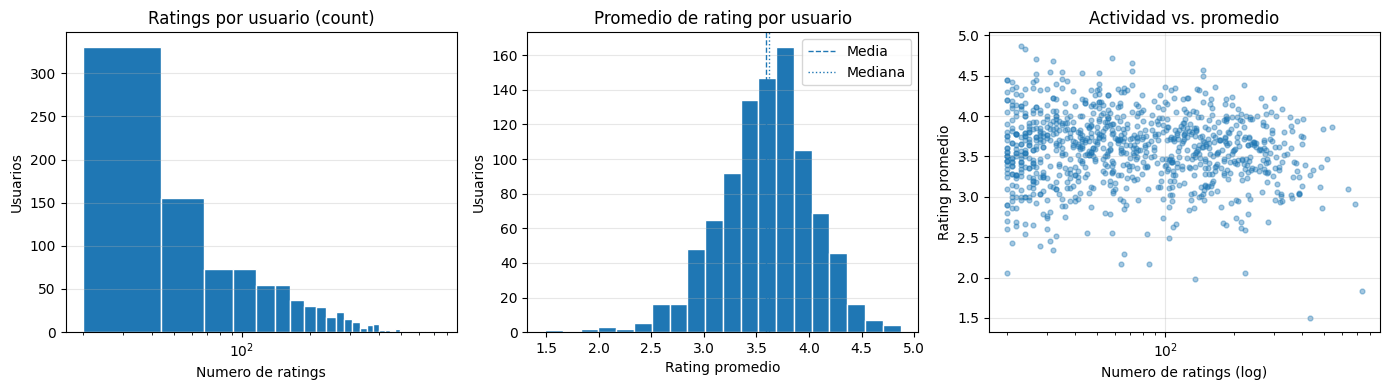

In [150]:
import matplotlib.pyplot as plt

# Compute per-user statistics: number of ratings and average rating
user_stats = (
    ratings.groupby("user_id")["rating"]
    .agg(count="count", mean="mean")
    .reset_index()
)

# Create a 1x3 layout for the plots
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# --- Plot 1: histogram of ratings count per user (log x-scale) ---
axes[0].hist(user_stats["count"], bins=30, edgecolor="white")
axes[0].set(title="Ratings por usuario (count)", xlabel="Numero de ratings", ylabel="Usuarios")
axes[0].set_xscale("log")
axes[0].grid(axis="y", alpha=0.3)

# --- Plot 2: histogram of mean rating per user + mean/median reference lines ---
axes[1].hist(user_stats["mean"], bins=20, edgecolor="white")
axes[1].set(title="Promedio de rating por usuario", xlabel="Rating promedio", ylabel="Usuarios")
m, md = user_stats["mean"].agg(["mean", "median"])
axes[1].axvline(m, linestyle="--", linewidth=1, label="Media")
axes[1].axvline(md, linestyle=":", linewidth=1, label="Mediana")
axes[1].legend()
axes[1].grid(axis="y", alpha=0.3)

# --- Plot 3: activity (count) vs average rating scatter (log x-scale) ---
axes[2].scatter(user_stats["count"], user_stats["mean"], alpha=0.4, s=12)
axes[2].set(title="Actividad vs. promedio", xlabel="Numero de ratings (log)", ylabel="Rating promedio")
axes[2].set_xscale("log")
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()


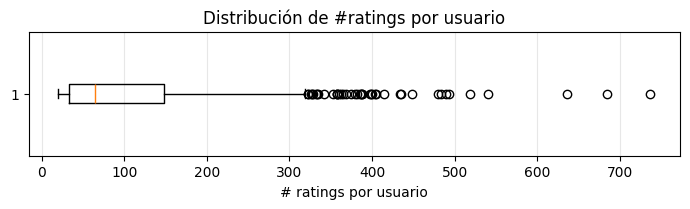

In [151]:
x = user_stats["count"]

fig, ax = plt.subplots(figsize=(7, 2.2))
ax.boxplot(x, vert=False, showfliers=True)
ax.set(title="Distribución de #ratings por usuario", xlabel="# ratings por usuario")
ax.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()

### ¿Cómo es la distribución del promedio de calificación por usuario?

- La actividad por usuario presenta una cola a la derecha: aunque el dataset está filtrado (mínimo 20 ratings), la media (106) es mayor que la mediana (65), indicando que unos pocos usuarios muy activos elevan el promedio. En este contexto, la mediana y los percentiles (p75=148, p90≈244, p95≈311) describen mejor el comportamiento típico.

- Los promedios de rating por usuario se concentran alrededor de 3.6 con dispersión moderada (σ≈0.45); aproximadamente la mitad de los usuarios cae entre 3.32 y 3.87, con pocos casos extremos. Esto sugiere heterogeneidad en la escala personal de calificación, por lo que es razonable incorporar bias por usuario (y regularización) para mejorar la precisión y evitar que usuarios con baja actividad distorsionen recomendaciones.

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
50%       65.000000
75%      148.000000
90%      244.400000
95%      310.600000
max      737.000000
Name: count, dtype: float64


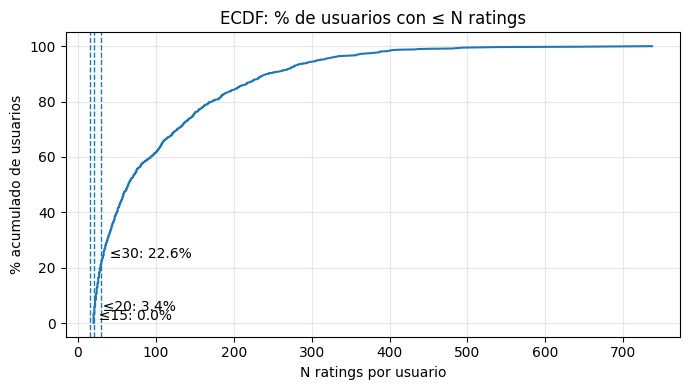

In [152]:
# Fast metrics of activity x user
count_stats = user_stats['count']
summary = count_stats.describe(percentiles=[0.5, 0.75, 0.9, 0.95])
cold_15 = (count_stats <= 15).mean() * 100
cold_20 = (count_stats <= 20).mean() * 100
cold_30 = (count_stats <= 30).mean() * 100

print(summary)

x = user_stats["count"].to_numpy()

# ECDF: sorted values vs cumulative proportion
xs = np.sort(x)
ys = np.arange(1, len(xs) + 1) / len(xs) * 100  # percent

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(xs, ys)  # ECDF line

# Mark thresholds of interest (15, 20, 30)
for t in [15, 20, 30]:
    pct = (x <= t).mean() * 100
    ax.axvline(t, linestyle="--", linewidth=1)
    ax.text(t, pct, f"  ≤{t}: {pct:.1f}%", va="bottom")

ax.set(
    title="ECDF: % de usuarios con ≤ N ratings",
    xlabel="N ratings por usuario",
    ylabel="% acumulado de usuarios",
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [153]:
# 1) Promedio de rating por usuario
mean_rating_per_user = ratings.groupby("user_id")["rating"].mean()

# 2) Resumen estadístico
summary = mean_rating_per_user.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95])
print("Resumen del promedio de rating por usuario:\n", summary)


Resumen del promedio de rating por usuario:
 count    943.000000
mean       3.588191
std        0.445233
min        1.491954
5%         2.863739
25%        3.323054
50%        3.620690
75%        3.869565
95%        4.295854
max        4.869565
Name: rating, dtype: float64


Los promedios por usuario se concentran alrededor de 3.6 con dispersión moderada (σ≈0.45); la mitad de los usuarios tiene promedios entre 3.32 y 3.87, con pocos usuarios extremos, lo que sugiere heterogeneidad en la escala personal de calificación y justifica incorporar bias por usuario.

## En la siguiente celda se esta calculando el número de ratings por items, el promedio de sus calificaciones y la varianza de sus calificaciones.

In [154]:
ratings.groupby('item_id')['rating'].agg({'count','mean','var'}).join(items['movie title'], how='left')

,mean,var,count,movie title
item_id,,,,
1,3.878319,0.860992,452,GoldenEye (1995)
2,3.206107,0.934116,131,Four Rooms (1995)
3,3.033333,1.470787,90,Get Shorty (1995)
4,3.550239,0.931358,209,Copycat (1995)
5,3.302326,0.895759,86,Shanghai Triad (Yao a yao yao dao waipo qiao) ...
...,...,...,...,...
1678,1.000000,NaN,1,B. Monkey (1998)
1679,3.000000,NaN,1,Sliding Doors (1998)
1680,2.000000,NaN,1,You So Crazy (1994)


### Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuáles son los items con más calificaciones?

¿Se puede observar el fenomeno de cola larga en este dataset?




In [155]:
mt = (ratings.groupby('item_id')['rating']
      .agg(['count','mean','var'])
      .join(items['movie title'], how='left'))

### ¿Cuáles son los items con más calificaciones?

Los ítems con más calificaciones corresponden a las películas más populares del dataset (las que concentran más interacciones). Al ordenar por count, se observa que existe un grupo pequeño de películas “top” con cientos de ratings, mientras que la mayoría no alcanza esos niveles de popularidad. Esto indica que la interacción no está distribuida de forma uniforme entre películas: unas pocas reciben mucha atención y muchas reciben poca.

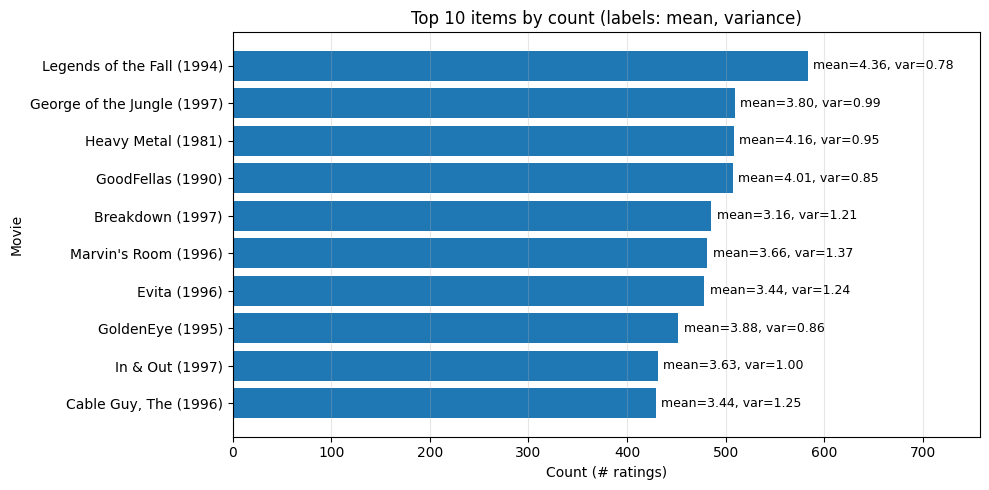

In [156]:
top_items = (mt.sort_values('count', ascending=False)
               .loc[:, ['movie title','count','mean','var']]
               .head(10))

df = top_items.copy().sort_values("count", ascending=True)

fig, ax = plt.subplots(figsize=(10, 5))
bars = ax.barh(df["movie title"], df["count"])

ax.set(title="Top 10 items by count (labels: mean, variance)",
       xlabel="Count (# ratings)", ylabel="Movie")
ax.grid(axis="x", alpha=0.3)

# Build labels first and compute a safe right margin
labels = [f"mean={m:.2f}, var={v:.2f}" for m, v in zip(df["mean"], df["var"])]
max_count = df["count"].max()
pad = max_count * 0.30          # 30% extra room (tune 0.20–0.50 if needed)
ax.set_xlim(0, max_count + pad) # ensures text fits inside axes

for bar, lab in zip(bars, labels):
    w = bar.get_width()
    y = bar.get_y() + bar.get_height()/2
    ax.text(w + max_count*0.01, y, lab, va="center", ha="left", fontsize=9)

plt.tight_layout()
plt.show()

### ¿Se puede observar el fenomeno de cola larga en este dataset?

- En el histograma (con eje x en escala log), la mayor parte de los ítems está concentrada en conteos muy bajos (pocos ratings por ítem).

- A medida que aumenta el número de ratings, la frecuencia de ítems cae rápido, pero aún aparecen ítems con decenas y hasta cientos de ratings: esa “extensión” hacia la derecha es la cola.

- En otras palabras: muchísimos ítems poco populares y muy pocos ítems muy populares (distribución altamente sesgada / heavy-tailed).

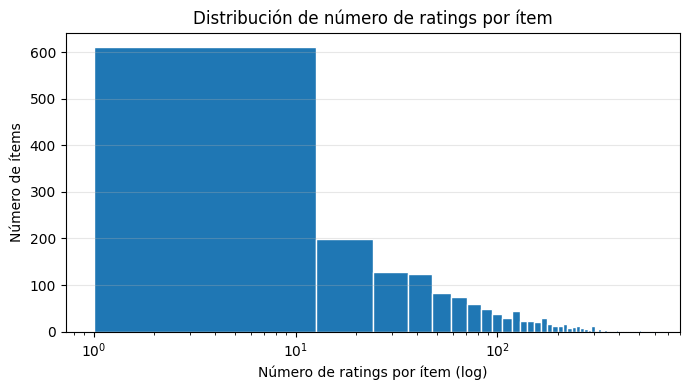

% de ratings en el Top 10 ítems: 4.9%
% de ratings en el Top 10% de ítems: 42.7%


In [157]:
# Get item rating counts (drop missing values just in case)
counts = mt["count"].dropna()

# ---- Plot: distribution of ratings per item (log scale) ----
fig, ax = plt.subplots(figsize=(7, 4))
ax.hist(counts, bins=50, edgecolor="white")
ax.set_xscale("log")
ax.set(
    title="Distribución de número de ratings por ítem",
    xlabel="Número de ratings por ítem (log)",
    ylabel="Número de ítems",
)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ---- Concentration metrics (share of total ratings) ----
total = counts.sum()

# Sort once and reuse
sorted_counts = counts.sort_values(ascending=False)

# Share of ratings coming from the top 10 most-rated items
share_top_10 = sorted_counts.head(10).sum() / total * 100

# Share of ratings coming from the top 10% most-rated items
top_10pct_n = max(1, int(len(sorted_counts) * 0.10))  # ensure at least 1 item
share_top_10pct = sorted_counts.head(top_10pct_n).sum() / total * 100

print(f"% de ratings en el Top 10 ítems: {share_top_10:.1f}%")
print(f"% de ratings en el Top 10% de ítems: {share_top_10pct:.1f}%")

## Creación de listas de recomendación no personalizadas

Genere inicialmente una lista de recomendación de tamaño 10 no personalizada con los items con mejor promedio, en teoría estos son los mejores items del dataset.

¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?

Ver: 

http://www.evanmiller.org/how-not-to-sort-by-average-rating.html

https://es.wikipedia.org/wiki/Intervalo_de_confianza


### ¿Qué problemas tiene generar una lista no personalizada solamente con el promedio?

- Sesgo por baja cantidad de ratings (promedios inflados): una película con 1–5 calificaciones puede tener promédio 5.0 y aparecer arriba, pero es poco confiable. Si no se considera el número de ratings, se corre el riesgo de recomendar ítems con alta calificación pero poca interacción, lo que puede resultar en recomendaciones de baja calidad o relevancia para los usuarios. El promedio por sí solo no distingue confianza.
- No es personalizado: ignora gustos del usuario. Un top global puede recomendar géneros que el usuario detesta (ej. terror), aunque el promedio sea alto.
- No se tienen en cuenta sesgos de calificación: algunos usuarios pueden ser más generosos o estrictos, lo que afecta el promedio sin reflejar la calidad real del ítem.
- Rankings por promedio son vulnerables a manipulación (pocas calificaciones altas suben mucho el promedio).

In [158]:
# Top-10 non-personalized recommendations: items with the highest mean rating
top10_best_avg = (
    mt.dropna(subset=["mean"])                 # ensure mean exists
      .sort_values("mean", ascending=False)    # rank by average rating
      .loc[:, ["movie title", "mean", "count"]]# keep useful columns (count helps interpret reliability)
      .head(10)
      .reset_index(drop=True)
)

top10_best_avg

,movie title,mean,count
0,One Fine Day (1996),5.0,1
1,Guantanamera (1994),5.0,1
2,"Maybe, Maybe Not (Bewegte Mann, Der) (1994)",5.0,1
3,"Last Time I Saw Paris, The (1954)",5.0,1
4,Chairman of the Board (1998),5.0,1
5,Ayn Rand: A Sense of Life (1997),5.0,3
6,Prisoner of the Mountains (Kavkazsky Plennik) ...,5.0,2
7,That Old Feeling (1997),5.0,3
8,Cosi (1996),5.0,1
9,"Cure, The (1995)",5.0,2


### ¿Es posible generar una mejor lista de recomendación teniendo en cuenta que tanto el número de ratings del item como su promedio?


#### SETUP Inicial

In [159]:
# Build an item lookup table (index = item_id) so we can join titles efficiently
items_idx = (
    items.rename(columns={"movie id": "item_id"})  # standardize column name to match ratings
         .set_index("item_id")                     # set item_id as index for fast lookups/joins
)

# Validate that every item_id in ratings has a corresponding title in the items table
def validate_titles(ratings: pd.DataFrame, items_idx: pd.DataFrame) -> None:
    # Number of unique items that appear in the ratings data
    unique_items = ratings["item_id"].nunique()

    # Count how many rated items are missing from the title index
    # (i.e., item_id not found in items_idx.index)
    missing = unique_items - ratings["item_id"].isin(items_idx.index).sum()

    print(f"Items únicos en ratings: {unique_items}")
    print(f"Items sin título: {missing} ({missing/unique_items*100:.2f}%)")

    # Perform a small join to directly measure how many titles become NaN after the join
    # - drop_duplicates(): one row per item_id
    # - join(..., how="left"): keep all rated item_ids, attach movie title when available
    check = (
        ratings[["item_id"]]
        .drop_duplicates()
        .join(items_idx["movie title"], on="item_id", how="left")
    )

    # Percentage of titles that are NaN (missing) after the join
    print(f"% títulos NaN tras join: {check['movie title'].isna().mean()*100:.2f}%")

# Run the validation
validate_titles(ratings, items_idx)

# Create a reusable per-item feature table:
# - count: number of ratings per item
# - mean: average rating per item
# - var: variance of ratings per item
# Then attach the movie title via a left join
mt = (
    ratings.groupby("item_id")["rating"]
           .agg(count="count", mean="mean", var="var")
           .join(items_idx["movie title"], how="left")
)


Items únicos en ratings: 1682
Items sin título: -98318 (-5845.30%)
% títulos NaN tras join: 0.00%


#### How Not To Sort By Average Rating

Este método no ordena por promedio. Primero convierte cada rating en un “like” (1 si rating ≥ threshold, si no 0). Luego, para cada ítem calcula cuántos likes tiene (pos) y cuántos votos totales (n). En vez de usar la proporción pos/n, calcula el límite inferior del intervalo de confianza de Wilson, que es una estimación conservadora del “porcentaje real de likes”. Así, los ítems con pocos ratings quedan penalizados por la incertidumbre y no dominan el ranking solo por tener un promedio alto con pocas observaciones.

Referencia: https://www.evanmiller.org/how-not-to-sort-by-average-rating.html

In [160]:
def rank_wilson(
    ratings: pd.DataFrame,
    items_idx: pd.DataFrame,
    threshold: int = 4,
    z: float = 1.96,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Rank items using the Wilson score lower bound for a binary "like" rate.

    Idea:
    - Convert star ratings into a binary outcome (positive / not positive) using `threshold`.
    - For each item, estimate the proportion of positives (p̂ = pos / n).
    - Compute the *lower bound* of the Wilson confidence interval for that proportion.
      This penalizes items with very small n (few ratings), preventing them from
      dominating the ranking just because they have a perfect average by chance.

    Returns:
    - rank: full ranking dataframe (all items), sorted by Wilson lower bound
    - top: top_n rows with key columns
    """

    # 1) Binarize ratings: 1 if rating >= threshold else 0
    tmp = ratings.assign(positive=(ratings["rating"] >= threshold).astype(int))

    # 2) Aggregate per item:
    #    pos = number of positive ratings
    #    n   = total number of ratings
    pn = tmp.groupby("item_id")["positive"].agg(pos="sum", n="count")

    # 3) Compute the observed positive rate p̂ for each item
    phat = pn["pos"] / pn["n"]
    n = pn["n"]

    # 4) Wilson score lower bound for the proportion:
    #    lower bound = conservative estimate of "true" positive rate,
    #    given uncertainty due to finite sample size.
    pn["wilson_lb"] = (
        (phat + z*z/(2*n) - z*np.sqrt((phat*(1-phat) + z*z/(4*n))/n)) /
        (1 + z*z/n)
    )

    # 5) Attach movie titles and rank descending by Wilson lower bound
    rank = (
        pn.join(items_idx["movie title"], how="left")
          .sort_values("wilson_lb", ascending=False)
    )

    # 6) Extract the top-N items with the most relevant columns
    top = rank.head(top_n)[["movie title", "pos", "n", "wilson_lb"]]

    return rank, top


rank_full_wilson, top10_wilson = rank_wilson(ratings, items_idx)
top10_wilson


,movie title,pos,n,wilson_lb
item_id,,,,
64,"Shawshank Redemption, The (1994)",255,283,0.860720
479,Vertigo (1958),162,179,0.853178
318,Schindler's List (1993),265,298,0.848560
98,"Silence of the Lambs, The (1991)",344,390,0.846252
483,Casablanca (1942),216,243,0.843166
603,Rear Window (1954),185,209,0.834823
427,To Kill a Mockingbird (1962),193,219,0.831730
50,Star Wars (1977),501,583,0.828769
357,One Flew Over the Cuckoo's Nest (1975),230,264,0.825420


#### Resumen del método: *LCB de la media (Intervalo de confianza)*

Este ranking ordena ítems usando una estimación **conservadora** del promedio de rating: el **límite inferior del intervalo de confianza (IC)** de la media. Para cada ítem se calcula:

\[LCB = \bar{x} - z \cdot \frac{s}{\sqrt{n}}\]

donde \(\bar{x}\) es el promedio del ítem, \(s\) su desviación estándar (a partir de la varianza) y \(n\) el número de ratings.
Así, ítems con **pocos ratings** (mayor incertidumbre) o **alta variabilidad** reciben una **penalización** y bajan en el ranking, evitando que promedios altos pero poco confiables dominen. Además, se filtran ítems con `count < min_count` para reducir estimaciones inestables.

Referencia: https://es.wikipedia.org/wiki/Intervalo_de_confianza


In [161]:
def rank_ci_mean_lcb(
    mt: pd.DataFrame,
    z: float = 1.96,
    min_count: int = 50,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Rank items using the *lower confidence bound* (LCB) of the item mean rating
    under a normal-approximation confidence interval.

    Expected columns in `mt`:
    - count: number of ratings for the item
    - mean : average rating for the item
    - var  : variance of ratings for the item
    - movie title: item title

    Returns:
    - rank: full ranking dataframe sorted by lcb_mean (descending)
    - top : top_n rows with key columns
    """

    # 1) Filter out items with too few ratings to make the CI meaningful
    #    (enforce at least 2 ratings, and also the user-specified min_count)
    df = mt[mt["count"] >= max(min_count, 2)].copy()

    # 2) Convert variance to standard deviation (handle missing variance as 0)
    df["std"] = np.sqrt(df["var"].fillna(0))

    # 3) Compute the lower confidence bound for the mean:
    #    LCB = mean - z * (std / sqrt(n))
    #    This penalizes items with high uncertainty (small n or large std).
    df["lcb_mean"] = df["mean"] - z * (df["std"] / np.sqrt(df["count"]))

    # 4) Rank items by the most conservative (lower bound) estimate of their mean
    rank = df.sort_values("lcb_mean", ascending=False)

    # 5) Return both the full ranking and the top-N subset
    top = rank.head(top_n)[["movie title", "count", "mean", "lcb_mean"]]
    return rank, top


rank_full_ci, top10_ci_mean = rank_ci_mean_lcb(mt, min_count=50)
top10_ci_mean


,movie title,count,mean,lcb_mean
item_id,,,,
318,Schindler's List (1993),298,4.466443,4.372306
483,Casablanca (1942),243,4.456790,4.365241
64,"Shawshank Redemption, The (1994)",283,4.445230,4.355866
408,"Close Shave, A (1995)",112,4.491071,4.348271
169,"Wrong Trousers, The (1993)",118,4.466102,4.317496
603,Rear Window (1954),209,4.387560,4.290955
50,Star Wars (1977),583,4.358491,4.286948
12,"Usual Suspects, The (1995)",267,4.385768,4.286749
114,Wallace & Gromit: The Best of Aardman Animatio...,67,4.447761,4.264717


#### Promedio bayesiano (Bayesian/weighted average)

Este método calcula un **promedio bayesiano/ponderado** para rankear ítems, combinando el promedio del ítem con el **promedio global** del dataset:

\[score = \frac{v}{v+m}R + \frac{m}{v+m}C\]

donde **v** es el número de ratings del ítem, **R** su promedio, **C** el promedio global, y **m** controla cuánto se “suaviza” (shrinkage) hacia **C**.
Así, los ítems con **pocos ratings** no quedan arriba solo por tener un promedio alto con poca evidencia: su score se acerca a **C**; en cambio, ítems con **muchos ratings** se acercan a su propio promedio **R**. En este código, **m** se elige como un **cuantil** (por defecto, el percentil 90) del `count`.



In [162]:
def rank_bayesian_average(
    mt: pd.DataFrame,
    global_mean: float,
    m_quantile: float = 0.90,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Rank items using a Bayesian/weighted average score.

    Score:
      score = (v / (v + m)) * R + (m / (v + m)) * C

    v = item rating count
    R = item mean rating
    C = global mean rating
    m = smoothing parameter (chosen as a quantile of v)
    """
    # Copy to avoid mutating the original dataframe
    df = mt.copy()

    # Choose m as a high quantile of item counts (e.g., 90th percentile).
    # Larger m => stronger shrinkage toward the global mean for low-count items.
    m = df["count"].quantile(m_quantile)

    # Compute Bayesian/weighted score:
    # - If v >> m, score ~ R (item has plenty of ratings, trust its mean)
    # - If v << m, score ~ C (item has few ratings, shrink toward global mean)
    df["score_bayes"] = (
        (df["count"] / (df["count"] + m)) * df["mean"]
        + (m / (df["count"] + m)) * global_mean
    )

    # Rank items by the Bayesian score (highest first)
    rank = df.sort_values("score_bayes", ascending=False)

    # Top-N view
    top = rank.head(top_n)[["movie title", "count", "mean", "score_bayes"]]
    return rank, top


# Global mean rating across all ratings (C)
C = ratings["rating"].mean()

# Rank and get top 10 using m as the 90th percentile of counts
rank_full_bayes, top10_bayes = rank_bayesian_average(mt, global_mean=C, m_quantile=0.90)
top10_bayes


,movie title,count,mean,score_bayes
item_id,,,,
50,Star Wars (1977),583,4.358491,4.172269
318,Schindler's List (1993),298,4.466443,4.127508
64,"Shawshank Redemption, The (1994)",283,4.445230,4.102979
483,Casablanca (1942),243,4.456790,4.076569
127,"Godfather, The (1972)",413,4.283293,4.064513
98,"Silence of the Lambs, The (1991)",390,4.289744,4.060011
12,"Usual Suspects, The (1995)",267,4.385768,4.054005
174,Raiders of the Lost Ark (1981),420,4.252381,4.045070
313,Titanic (1997),350,4.245714,4.012613


#### Resumen del método: *Evan Miller Star Ratings (Dirichlet + LCB)*

Este método rankea ítems con **ratings en estrellas (1–K)** usando un enfoque bayesiano. Primero cuenta cuántas veces cada ítem recibió 1, 2, …, K estrellas y aplica un prior **Dirichlet(1..1)** (equivalente a sumar **1 pseudo-voto** a cada estrella) para evitar promedios extremos cuando hay pocos datos. Con las probabilidades posteriores calcula el **promedio bayesiano** \(\mu\) y una medida de **incertidumbre** (varianza). Finalmente asigna un puntaje **conservador** como límite inferior:

\[
score = \mu - z \cdot \sqrt{var}
\]

Así, ítems con **pocos ratings** reciben una penalización por incertidumbre y no dominan el ranking solo por tener un promedio alto con poca evidencia.

Referencia: https://www.evanmiller.org/ranking-items-with-star-ratings.html


In [163]:
def rank_miller_star(
    ratings: pd.DataFrame,
    items_idx: pd.DataFrame,
    K: int = 5,
    z: float = 1.65,
    top_n: int = 10
) -> tuple[pd.DataFrame, pd.DataFrame]:
    """
    Rank items using Evan Miller's approach for star ratings:
    - Model rating probabilities with a Dirichlet(1..1) prior (Laplace smoothing).
    - Compute the Bayesian expected mean rating (posterior mean).
    - Compute a conservative score as a lower confidence bound (LCB):
        score = bayes_mean - z * sqrt(posterior_variance_of_mean)

    Returns:
    - rank: full ranking dataframe (all items), sorted by score desc
    - top : top_n rows with key columns
    """

    # 1) Define the possible star values: 1..K
    s = np.arange(1, K + 1)

    # 2) Build a contingency table: counts per item_id and rating value
    #    Ensure all columns 1..K exist, fill missing with 0
    nk = (
        pd.crosstab(ratings["item_id"], ratings["rating"])
          .reindex(columns=s, fill_value=0)
    )

    # 3) Total number of ratings per item
    N = nk.sum(axis=1)

    # 4) Dirichlet(1..1) prior => add 1 pseudo-count to each star bin
    #    Posterior mean probabilities:
    #      p_k = (n_k + 1) / (N + K)
    p = (nk + 1).div(N + K, axis=0)

    # 5) Bayesian expected mean rating:
    #      mu = sum_k p_k * k
    mu = (p * s).sum(axis=1)

    # 6) Second moment:
    #      m2 = sum_k p_k * k^2
    m2 = (p * (s**2)).sum(axis=1)

    # 7) Posterior variance of the mean estimate (Dirichlet posterior)
    #    This term captures uncertainty: fewer ratings => larger variance
    var = (m2 - mu**2) / (N + K + 1)

    # 8) Conservative score (lower bound):
    #      score = mu - z * sqrt(var)
    #    Higher z => more conservative (stronger penalty for uncertainty)
    score = mu - z * np.sqrt(var)

    # 9) Build ranking table, attach titles, sort by score descending
    rank = pd.DataFrame({"count": N, "bayes_mean": mu, "score": score})
    rank.index.name = "item_id"

    rank = (
        rank.join(items_idx["movie title"], how="left")
            .sort_values("score", ascending=False)
    )

    # 10) Top-N items
    top = rank.head(top_n)[["movie title", "count", "bayes_mean", "score"]]
    return rank, top


rank_full_miller, top10_miller = rank_miller_star(ratings, items_idx)
top10_miller


,movie title,count,bayes_mean,score
item_id,,,,
318,Schindler's List (1993),298,4.442244,4.360743
483,Casablanca (1942),243,4.427419,4.346453
64,"Shawshank Redemption, The (1994)",283,4.420139,4.342105
408,"Close Shave, A (1995)",112,4.427350,4.296646
50,Star Wars (1977),583,4.346939,4.286076
12,"Usual Suspects, The (1995)",267,4.360294,4.274515
169,"Wrong Trousers, The (1993)",118,4.406504,4.273117
603,Rear Window (1954),209,4.355140,4.269134
98,"Silence of the Lambs, The (1991)",390,4.273418,4.202315


#### Comparación de rankings: similitud Jaccard entre Top-N sets

La matriz muestra qué tanto se solapan los Top-10 entre métodos (Jaccard = 1 idénticos, 0 sin intersección). En tu caso, no hay un consenso total: la mayoría de pares quedan en un solapamiento moderado (0.43–0.67).

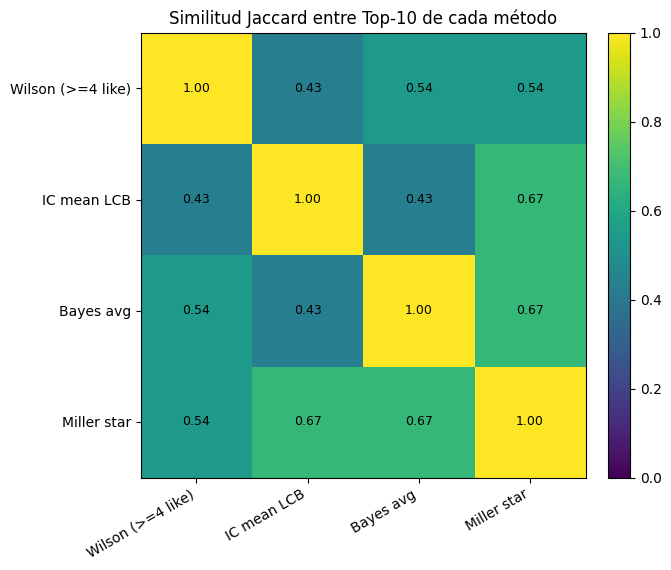

In [164]:
TOP_N = 10
Z_95 = 1.96   # ~95% normal CI
Z_90 = 1.65   # ~90% normal CI (often used as a slightly less conservative bound)

# -----------------------------
# 1) Compute full rankings once
# -----------------------------
# Global mean rating (used by Bayesian average)
C = ratings["rating"].mean()

# Each function returns (full_ranking_df, top_n_df) → we keep only the full ranking
rank_full = {
    "Wilson (>=4 like)": rank_wilson(ratings, items_idx, threshold=4, z=Z_95, top_n=TOP_N)[0],
    # Use min_count to avoid items with very few perfect ratings dominating
    "IC mean LCB":       rank_ci_mean_lcb(mt, z=Z_95, min_count=50, top_n=TOP_N)[0],
    "Bayes avg":         rank_bayesian_average(mt, global_mean=C, m_quantile=0.90, top_n=TOP_N)[0],
    "Miller star":       rank_miller_star(ratings, items_idx, K=5, z=Z_90, top_n=TOP_N)[0],
}

# Map each method to the column that contains its scoring metric
score_col = {
    "Wilson (>=4 like)": "wilson_lb",
    "IC mean LCB":       "lcb_mean",
    "Bayes avg":         "score_bayes",
    "Miller star":       "score",
}


# -------------------------------------------
# 2) Build Top-N sets (item_id indices) per method
# -------------------------------------------
# Convert each score series into a set of the Top-N item_ids
top_sets = {
    name: set(rank_full[name][score_col[name]].dropna().nlargest(TOP_N).index)
    for name in rank_full
}

names = list(top_sets.keys())

# --------------------------
# 3) Jaccard similarity matrix
# --------------------------
def jaccard(A: set, B: set) -> float:
    """Jaccard(A,B) = |A∩B| / |A∪B|; returns 0 if both sets are empty."""
    union = A | B
    return (len(A & B) / len(union)) if union else 0.0

# Build a square matrix where (i,j) = Jaccard similarity between Top-N sets
jacc = np.array([[jaccard(top_sets[a], top_sets[b]) for b in names] for a in names])

# --------------------------
# 4) Plot heatmap + annotations
# --------------------------
fig, ax = plt.subplots(figsize=(7, 5.8))
im = ax.imshow(jacc, vmin=0, vmax=1)

ax.set_xticks(range(len(names)))
ax.set_xticklabels(names, rotation=30, ha="right")
ax.set_yticks(range(len(names)))
ax.set_yticklabels(names)

ax.set_title(f"Similitud Jaccard entre Top-{TOP_N} de cada método")

# Write the numeric values inside each cell
for (i, j), val in np.ndenumerate(jacc):
    ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)

fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()


- Se observa un núcleo estable: varias películas se mantienen con rangos muy cercanos (≈1–5) en casi todos los métodos. Eso indica consenso entre rankings cuando el ítem tiene señal fuerte (buen desempeño y evidencia suficiente).

- El método Bayes avg introduce los cambios más grandes (líneas con caídas pronunciadas en la tercera columna). Esto es consistente con que Bayes avg hace shrinkage hacia la media global y suele favorecer ítems con mucha evidencia (count alto), reordenando el Top-10 respecto a métodos más “conservadores” por incertidumbre.

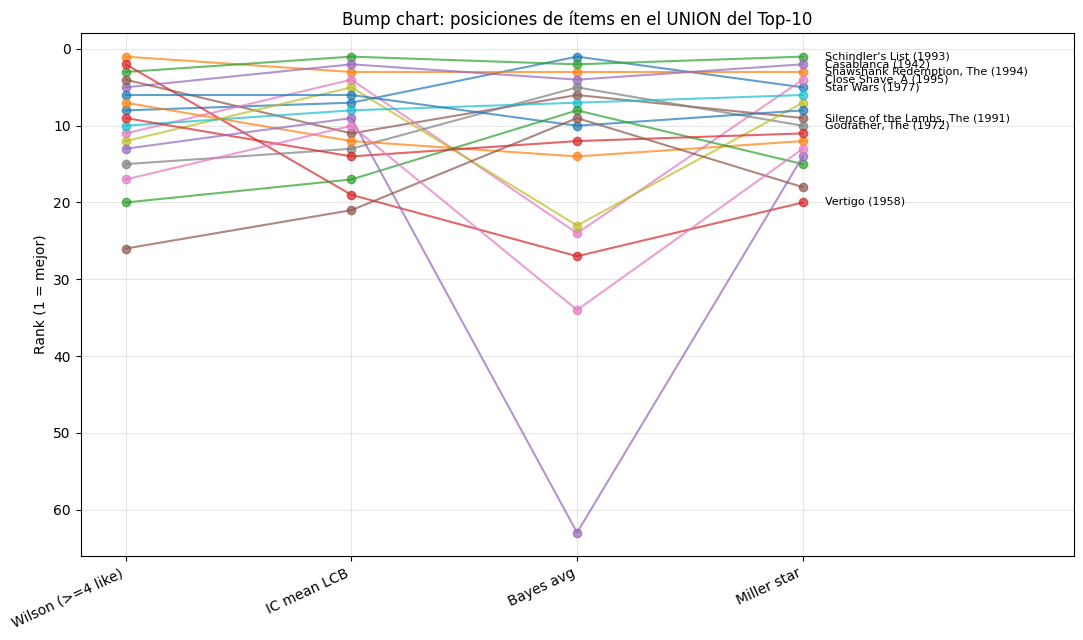

In [165]:
# ==========================================
# B) BUMP CHART: ranks over UNION of Top-N
# ==========================================
# Goal: compare how the same items move in rank across methods.

methods = {
    "Wilson (>=4 like)": rank_full_wilson["wilson_lb"],
    "IC mean LCB": rank_full_ci["lcb_mean"],
    "Bayes avg": rank_full_bayes["score_bayes"],
    "Miller star": rank_full_miller["score"],
}

# 1) Union of all Top-N items across methods (items to display)
union_items = sorted(set().union(*top_sets.values()))

# 2) Build a rank table: rows=item_id, cols=method, values=global rank (1 = best)
rank_df = pd.DataFrame(index=union_items)

for name, score in methods.items():
    # Compute global ranks for the method (higher score => better rank)
    r = score.rank(ascending=False, method="min")

    # If an item is missing in this method (e.g., filtered out), assign it a worst rank
    worst_rank = r.max() + 1

    # Align ranks to the union index and fill missing with worst_rank
    rank_df[name] = r.reindex(union_items).fillna(worst_rank)

# Optional: add titles for labeling/inspection
rank_df = rank_df.join(items_idx["movie title"], how="left")

# 3) Sort items so those that are "best in any method" appear first (cleaner plot)
rank_df["best_rank"] = rank_df[names].min(axis=1)
rank_df = rank_df.sort_values("best_rank")

# 4) Plot bump chart
x = np.arange(len(names))
fig, ax = plt.subplots(figsize=(11, 6.5))

# Plot one line per item showing its rank across methods
ax.plot(x, rank_df[names].to_numpy().T, marker="o", alpha=0.7)

ax.invert_yaxis()  # rank 1 at the top
ax.set_xticks(x)
ax.set_xticklabels(names, rotation=25, ha="right")
ax.set_ylabel("Rank (1 = mejor)")
ax.set_title(f"Bump chart: posiciones de ítems en el UNION del Top-{TOP_N}")
ax.grid(alpha=0.3)

# Label only the top-k items (by best_rank) to avoid clutter
label_k = min(8, len(rank_df))
for _, row in rank_df.head(label_k).iterrows():
    ax.text(x[-1] + 0.10, row[names[-1]], row["movie title"], va="center", fontsize=8)

ax.set_xlim(-0.2, len(names) - 1 + 1.2)  # extra space to the right for labels
plt.tight_layout()
plt.show()


In [166]:
# top_sets: dict like {"Method A": {item_id,...}, "Method B": {...}, ...}
# items_idx: DataFrame indexed by item_id with a "movie title" column

methods = list(top_sets)  # list of method names (dict keys)

# 1) Get the union of all item_ids that appear in any Top-10
union_items = sorted(set().union(*top_sets.values()))

# 2) Build a boolean presence/absence table: rows=items, cols=methods
overlap = pd.DataFrame(
    {m: [iid in top_sets[m] for iid in union_items] for m in methods},
    index=union_items
)

# 3) Add movie titles and summary columns
overlap = overlap.join(items_idx["movie title"], how="left")
overlap["num_methods"] = overlap[methods].sum(axis=1)  # how many methods include the item
overlap["methods"] = overlap[methods].apply(
    lambda r: ", ".join([m for m in methods if r[m]]),
    axis=1
)

# 4) Sort by agreement (more methods first), then by title
overlap = (overlap
           .reset_index()
           .rename(columns={"index": "item_id"})
           .sort_values(["num_methods", "movie title"], ascending=[False, True]))

# 5) Display a clean set of columns
cols = ["item_id", "movie title", "num_methods", "methods"] + methods
overlap[cols]

,item_id,movie title,num_methods,methods,Wilson (>=4 like),IC mean LCB,Bayes avg,Miller star
15,483,Casablanca (1942),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
16,603,Rear Window (1954),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
10,318,Schindler's List (1993),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
2,64,"Shawshank Redemption, The (1994)",4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
1,50,Star Wars (1977),4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
0,12,"Usual Suspects, The (1995)",4,"Wilson (>=4 like), IC mean LCB, Bayes avg, Mil...",True,True,True,True
3,98,"Silence of the Lambs, The (1991)",3,"Wilson (>=4 like), Bayes avg, Miller star",True,False,True,True
12,408,"Close Shave, A (1995)",2,"IC mean LCB, Miller star",False,True,False,True
5,127,"Godfather, The (1972)",2,"Bayes avg, Miller star",False,False,True,True
6,169,"Wrong Trousers, The (1993)",2,"IC mean LCB, Miller star",False,True,False,True


## Comparación de 4 métodos de ranking no personalizado (Top-10)

Para construir listas de recomendación **no personalizadas** (mismas recomendaciones para todos los usuarios), se evaluaron cuatro estrategias que intentan corregir el problema de **ordenar solo por promedio**: los ítems con pocas calificaciones pueden aparecer artificialmente “mejores” por azar.

### Hallazgos principales

- Los métodos que trabajan en escala de 1–5 con regularización (Bayes avg y Miller star) tienden a recomendar conjuntos muy similares.
- Wilson difiere más porque mide “consistencia de likes” (>=4) y no el promedio directo.

##### Películas recurrentes (overlap entre Top-10)
Se observa un **núcleo de películas** que aparece repetidamente en varios métodos (consenso).
En particular, varias películas aparecen en **todos los métodos**, lo que sugiere que son fuertes candidatas para una lista global no personalizada (alta calidad + buen soporte + consistencia).

# Creación del dataset de entrenamiento y prueba

El próximo paso es cargar los datos a surprise, para esto vamos a inicializar un modelo de datos de surprise con la información de los ratings cargados en el dataframe

In [167]:
reader = Reader( rating_scale = ( 1, 5 ) )
#Se crea el dataset a partir del dataframe
surprise_dataset = Dataset.load_from_df( ratings[ [ 'user_id', 'item_id', 'rating' ] ], reader )

Se divide el dataset en entrenamiento y test. El dataset de entrenamiento será presentado al algoritmo de recomendación y el dataset de test nos servirá para medir qué tan buenas fueron las predicciones del sistema de recomendación. El conjunto de test generado es una lista con los ratings de prueba

In [168]:
train_set, test_set=  train_test_split(surprise_dataset, test_size=.2)

In [169]:
train_set.n_ratings

80000

In [170]:
len(test_set)

20000

In [171]:
#Este es el primer elemento del dataset de prueba (usuario 154, película 302, rating 4)
test_set[0]

(154, 302, 4.0)

## Creación de modelo de filtrado colaborativo basado en similitud con usuarios o items cercanos

Surprise cuenta con la implementación de los modelos colaborativos dentro de la clase [KNNBasic](https://surprise.readthedocs.io/en/stable/knn_inspired.html) 

El modelo recibe los siguientes parámetros: 


*   k: El máximo número de vecinos con el que se hará la extrapolación
*   min_k : El mínimo número de vecinos con el que se extrapolará un rating
*   sim_options : Opciones de similitud pasadas como un diccionario de python, aqui se le configura al modelo el tipo de similitud a usar para encontrar los vecinos y si la extrapolación debe hacerse usando usuarios o items similares. Revise el formato y similitudes disponibles en surprise en [este link](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measure-configuration)





In [172]:
# se crea un modelo knnbasic item-item con similitud coseno 
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)

In [173]:
#Se le pasa la matriz de utilidad al algoritmo 
algo.fit(trainset=train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.


Una vez cargados los ratings al modelo, se puede realizar una predicción para un usuario, en este caso vamos a calcular la predicción que el modelo esta realizando para la primera entrada del dataset de test la predicción para el usuario con id 154 y el item con id 302, que corresponde a la película L.A. Confidential (1997)

---



In [174]:
#Verifique la propiedad est de la predicción
algo.predict(154,302)

Prediction(uid=154, iid=302, r_ui=None, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False})

In [175]:
items[items['movie id']==302]

,movie id,movie title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
301,302,L.A. Confidential (1997),01-Jan-1997,NaN,http://us.imdb.com/M/title-exact?L%2EA%2E+Conf...,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0


Como podemos ver, la predicción (4.24) del modelo no esta alejada de lo que realmente opinó el usuario  (4.0)

Para medir la calidad de la predicción para todos los usuarios e items del dataset de prueba, vamos a comparar lo que dice el modelo de predicción vs lo que dice el conjunto de prueba, para esto vamos a usar la métrica [RMSE](https://surprise.readthedocs.io/en/stable/accuracy.html#surprise.accuracy.rmse)

Inicialmente calculamos la predicción para todos los elementos del conjunto de test

In [176]:
test_predictions=algo.test(test_set)

In [177]:
#5 primeras predicciones
test_predictions[0:5]

[Prediction(uid=154, iid=302, r_ui=4.0, est=4.249202065377386, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=896, iid=484, r_ui=4.0, est=2.8976616922320964, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=230, iid=371, r_ui=4.0, est=4.1968378983432535, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=234, iid=294, r_ui=3.0, est=3.0978778071364186, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=25, iid=729, r_ui=4.0, est=4.148885433441103, details={'actual_k': 20, 'was_impossible': False})]

Ahora se mide el RMSE de las predicciones vs el valor del dataset

In [178]:
# En promedio, el sistema encuentra ratings que están una estrella por encima o por debajo del rating del usuario
rmse_ii_surprise = accuracy.rmse( test_predictions, verbose = True )
rmse_ii_surprise

RMSE: 1.0453


1.0453343976192102

## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?

#### ¿Cuál es el RMSE de un modelo usuario-usuario con los mismos parámetros de similitud?

In [179]:
# Modelo KNNBasic usuario-usuario con similitud coseno (mismos hiperparámetros)
sim_options_uu = {
    "name": "cosine",
    "user_based": True
}

algo_uu = KNNBasic(k=20, min_k=2, sim_options=sim_options_uu)

algo_uu.fit(train_set)

test_predictions_uu = algo_uu.test(test_set)

rmse_uu_surprise = accuracy.rmse(test_predictions_uu, verbose=True)
rmse_uu_surprise

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0166


1.0166414414593592

#### ¿Cuál es el efecto de cambiar el número de vecinos en la calidad del modelo usuario-usuario ?
En user–user, para predecir un ítem popular es fácil encontrar 20 usuarios que lo hayan calificado.
En item–item, para un usuario con pocas calificaciones, puede ser más difícil encontrar suficientes ítems realmente similares al ítem objetivo.

- Cuando k es pequeño (5–10) el error es más alto.
Con pocos vecinos, la predicción depende mucho de 2–3 usuarios “parecidos” → más ruido (alta varianza).

- Al subir k hasta ~30–40, RMSE y MAE bajan rápido.
Al agregar más evidencia se promedia mejor.

- A partir de k≈40, la curva se aplana (mejoras marginales casi nulas).
Ya se están incluyendo vecinos menos similares.

Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.


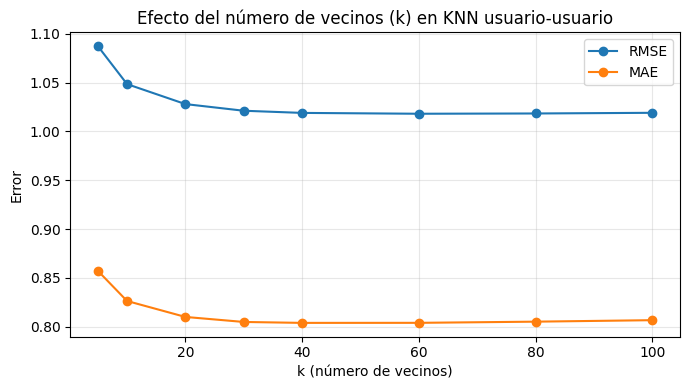

In [180]:
# 1) dataset + split reproducible
reader = Reader(rating_scale=(1, 5))
surprise_dataset = Dataset.load_from_df(ratings[['user_id', 'item_id', 'rating']], reader)

train_set, test_set = train_test_split(surprise_dataset, test_size=0.2, random_state=42)

# 2) rango de k a evaluar
k_values = [5, 10, 20, 30, 40, 60, 80, 100]

rmse_values = []
mae_values = []

sim_options = {
    "name": "cosine",
    "user_based": True  # usuario-usuario
}

for k in k_values:
    algo = KNNBasic(k=k, min_k=2, sim_options=sim_options)
    algo.fit(train_set)
    preds = algo.test(test_set)

    rmse = accuracy.rmse(preds, verbose=False)
    mae  = accuracy.mae(preds, verbose=False)

    rmse_values.append(rmse)
    mae_values.append(mae)

# 3) gráfica
plt.figure(figsize=(7,4))
plt.plot(k_values, rmse_values, marker="o", label="RMSE")
plt.plot(k_values, mae_values, marker="o", label="MAE")
plt.title("Efecto del número de vecinos (k) en KNN usuario-usuario")
plt.xlabel("k (número de vecinos)")
plt.ylabel("Error")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

## Generando listas de predicciones para los usuarios

Retomemos nuestro modelo inicial y ajustémolo con todos los ratings disponibles

Para generar una lista de recomendación se debe crear un dataset de "test" con las entradas faltantes de la matriz utilidad para que el modelo cree las predicciones (terminar de llenar la matriz de utilidad)



In [181]:
#Se crea el dataset para modelo 
rating_data=surprise_dataset.build_full_trainset()
# Se crea dataset de "prueba" con las entradas faltantes para generar las predicciones
test=rating_data.build_anti_testset()

# se crea el mismo modelo que el del ejemplo
sim_options = {'name': 'cosine',
               'user_based': False  # calcule similitud item-item
               }
algo = KNNBasic(k=20, min_k=2, sim_options=sim_options)
algo.fit(rating_data)
predictions=algo.test(test)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [182]:
#10 primeras predicciones
predictions[0:10]

[Prediction(uid=196, iid=302, r_ui=3.52986, est=3.4998074068929244, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=377, r_ui=3.52986, est=3.531852919263047, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=51, r_ui=3.52986, est=3.59549677885145, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=346, r_ui=3.52986, est=3.5471070543165877, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=474, r_ui=3.52986, est=3.7990088769026116, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=265, r_ui=3.52986, est=3.4464297466659812, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=465, r_ui=3.52986, est=3.5022156502733557, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=451, r_ui=3.52986, est=3.6948301041629965, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=86, r_ui=3.52986, e

In [183]:
#Predicciones para usuario 196
user_predictions=list(filter(lambda x: x[0]==196,predictions))

In [184]:
#Ordenamos de mayor a menor estimación de relevancia
user_predictions.sort(key=lambda x : x.est, reverse=True)

In [185]:
#tomamos las 10 primeras predicciones
user_predictions=user_predictions[0:10]

In [186]:
user_predictions

[Prediction(uid=196, iid=1309, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1310, r_ui=3.52986, est=4.5, details={'actual_k': 4, 'was_impossible': False}),
 Prediction(uid=196, iid=1676, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1675, r_ui=3.52986, est=4.25, details={'actual_k': 8, 'was_impossible': False}),
 Prediction(uid=196, iid=1289, r_ui=3.52986, est=4.202435603862276, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1643, r_ui=3.52986, est=4.097225899300029, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1593, r_ui=3.52986, est=4.090909090909091, details={'actual_k': 11, 'was_impossible': False}),
 Prediction(uid=196, iid=935, r_ui=3.52986, est=4.05136705364539, details={'actual_k': 20, 'was_impossible': False}),
 Prediction(uid=196, iid=1216, r_ui=3.52986, est=4.0506920732628675, details={'actual_k': 20, 'was_i

In [187]:
#Se convierte a dataframe
labels = ['movie id', 'estimation']
df_predictions = pd.DataFrame.from_records(list(map(lambda x: (x.iid, x.est) , user_predictions)), columns=labels)

In [188]:
#Lo unimos con el dataframe de películas
df_predictions.merge(items[['movie id','movie title','IMDb URL ']], how='left', on='movie id')

,movie id,estimation,movie title,IMDb URL
0,1309,4.500000,"Very Natural Thing, A (1974)",http://us.imdb.com/M/title-exact?Very%20Natura...
1,1310,4.500000,"Walk in the Sun, A (1945)",http://us.imdb.com/M/title-exact?Walk%20in%20t...
2,1676,4.250000,"War at Home, The (1996)",http://us.imdb.com/M/title-exact?War%20at%20Ho...
3,1675,4.250000,"Sunchaser, The (1996)","http://us.imdb.com/M/title-exact?Sunchaser,%20..."
4,1289,4.202436,Jack and Sarah (1995),http://us.imdb.com/M/title-exact?Jack%20and%20...
5,1643,4.097226,Angel Baby (1995),http://us.imdb.com/Title?Angel+Baby+(1995/I)
6,1593,4.090909,Death in Brunswick (1991),http://us.imdb.com/M/title-exact?Death%20in%20...
7,935,4.051367,Paradise Road (1997),http://us.imdb.com/M/title-exact?Paradise%20Ro...
8,1216,4.050692,Kissed (1996),http://us.imdb.com/M/title-exact?Kissed%20%281...
9,1312,4.049247,"Pompatus of Love, The (1996)",http://us.imdb.com/M/title-exact?Pompatus%20of...


## Utilice las siguientes celdas para encontrar la respuesta a las siguientes preguntas

Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

#### Cree al menos 2 usuarios (al primero asígnele el id 944) y cree para cada usuario ratings nuevos (puede hacerlo haciendo a traves del [dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html), o añadiendo líneas al archivo). Asigne a un usuario preferencias de un segmento popular (mainstream) y a otro preferencias de un nicho.

This cell creates **synthetic users** by appending new ratings to the dataset, in order to simulate different preference profiles (mainstream, niche, genre-specific) and then evaluate how the recommender behaves.

##### 1) Metadata preparation (`items_meta`)
- Computes `popularity` = number of ratings each movie has in the dataset.
- Merges popularity with `items` so we have, per movie:
  - `item_id`, `movie title`, genre flags (0/1), and `popularity`.

This enables selecting movies from the **head (popular)** or **long tail (rare)**.

##### 2) Helper functions (to keep the code clean)
- `filter_by_genres(df, genres)`: filters movies that belong to **at least one** of the given genres (OR logic).
- `pick_items(df, n, most_popular=True, exclude_ids=None)`: selects `n` movies ordered by popularity:
  - `most_popular=True` → mainstream/head items
  - `most_popular=False` → niche/long-tail items
  - `exclude_ids` avoids selecting the same movie twice.
- `sample_ratings(n, mode)`: generates rating values according to a style:
  - `polarized_high` (all 5), `polarized_low` (all 1)
  - `normal_high` (4–5), `normal_mid` (3–5), `normal_mixed` (2–5)
- `add_profile(rows, user_id, like_items, dislike_items, like_mode, dislike_mode)`: appends rating rows for a user:
  - assigns positive ratings to `like_items` using `like_mode`
  - optionally assigns negative ratings to `dislike_items` using `dislike_mode`

##### 3) Candidate pools (movie segments)
We define “pools” of movies to build profiles:
- `mainstream_pool`: used with high popularity (head)
- `niche_pool`: Film-Noir / Documentary / Western
- `filmnoir_pool`, `scifi_pool`, `romcom_pool`, `horror_pool`: genre-specific pools

##### 4) Profile generation (users 944–950)
Each synthetic user is defined by:
- a list of liked movies (`like_items`)
- optionally a list of disliked movies (`dislike_items`)
- a rating style (polarized vs more realistic)

Examples:
- **944**: mainstream polarized (5 for mainstream, 1 for niche)
- **945**: niche polarized (5 for niche, 1 for mainstream)
- **946**: Film-Noir only (only likes)
- **947–950**: more realistic profiles (ratings 2–5, less extreme)

##### 5) Creating `ratings_aug` and validation
- `new_df` contains only new ratings and removes duplicates.
- `ratings_aug` = original dataset + new ratings (unique per user-item).
- Prints how many new rows were added and counts per synthetic user.
- `added` shows a table of the inserted ratings, including title, popularity, and relevant genres.

**Output:** an augmented dataset (`ratings_aug`) with multiple synthetic user profiles, ready to train the recommender and analyze personalization, popularity bias, and long-tail behavior.


In [189]:
rng = np.random.default_rng(42)

item_pop = ratings.groupby("item_id").size().rename("popularity").reset_index()

items_meta = items.rename(columns={"movie id": "item_id"}).merge(
    item_pop, on="item_id", how="left"
).fillna({"popularity": 0})

genre_cols = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','unknown']

# Helper: filter by one or more genres (OR condition)
def filter_by_genres(df, genres):
    mask = np.zeros(len(df), dtype=bool)
    for g in genres:
        mask |= (df[g] == 1)
    return df[mask]

# Helper: pick items from a candidate pool
def pick_items(df, n, most_popular=True, exclude_ids=None):
    """
    Pick n item_ids from df, sorting by popularity.
    most_popular=True  -> head (popular)
    most_popular=False -> tail (long tail)
    """
    if exclude_ids is not None:
        df = df[~df["item_id"].isin(exclude_ids)]
    df = df.sort_values("popularity", ascending=not most_popular)
    return df["item_id"].head(n).astype(int).tolist()

# Helper: generate ratings (either fixed or sampled)
def sample_ratings(n, mode="polarized_high", rng=None):
    """
    mode:
      - 'polarized_high': all 5
      - 'polarized_low' : all 1
      - 'normal_high'   : random in {4,5}
      - 'normal_mid'    : random in {3,4,5}
      - 'normal_mixed'  : random in {2,3,4,5} (more realistic)
    """
    rng = rng or np.random.default_rng(0)
    if mode == "polarized_high":
        return [5]*n
    if mode == "polarized_low":
        return [1]*n
    if mode == "normal_high":
        return rng.integers(4, 6, size=n).tolist()     # 4–5
    if mode == "normal_mid":
        return rng.integers(3, 6, size=n).tolist()     # 3–5
    if mode == "normal_mixed":
        return rng.integers(2, 6, size=n).tolist()     # 2–5
    raise ValueError("Unknown mode")

# Helper: add one profile into a list of rows
def add_profile(rows, user_id, like_items, dislike_items=None,
                like_mode="polarized_high", dislike_mode="polarized_low",
                rng=None):
    """
    Adds ratings for a given user_id.
    - like_items: list of item_ids to rate positively
    - dislike_items: optional list of item_ids to rate negatively
    - like_mode/dislike_mode: how to generate ratings
    """
    rng = rng or np.random.default_rng(0)

    like_r = sample_ratings(len(like_items), mode=like_mode, rng=rng)
    for iid, r in zip(like_items, like_r):
        rows.append({"user_id": user_id, "item_id": int(iid), "rating": int(r)})

    if dislike_items:
        dislike_r = sample_ratings(len(dislike_items), mode=dislike_mode, rng=rng)
        for iid, r in zip(dislike_items, dislike_r):
            rows.append({"user_id": user_id, "item_id": int(iid), "rating": int(r)})

In [190]:
# Define candidate pool
mainstream_pool = items_meta.copy()  # we define mainstream via popularity later
niche_pool = filter_by_genres(items_meta, ["Film-Noir", "Documentary", "Western"])
filmnoir_pool = items_meta[items_meta["Film-Noir"] == 1]
scifi_pool = items_meta[items_meta["Sci-Fi"] == 1]
romcom_pool = filter_by_genres(items_meta, ["Romance", "Comedy"])
horror_pool = items_meta[items_meta["Horror"] == 1]

In [191]:
# Build profiles
new_rows = []

# Profile 944: mainstream lover (polarized)
main_like = pick_items(mainstream_pool, n=8, most_popular=True)
main_dislike = pick_items(niche_pool, n=2, most_popular=False, exclude_ids=set(main_like))
add_profile(new_rows, 944, main_like, main_dislike,
            like_mode="polarized_high", dislike_mode="polarized_low", rng=rng)

# Profile 945: niche lover (Film-Noir/Documentary/Western) (polarized)
niche_like = pick_items(niche_pool, n=8, most_popular=False)
niche_dislike = pick_items(mainstream_pool, n=2, most_popular=True, exclude_ids=set(niche_like))
add_profile(new_rows, 945, niche_like, niche_dislike,
            like_mode="polarized_high", dislike_mode="polarized_low", rng=rng)

# Profile 946: Film-Noir only (polarized)
noir_like = pick_items(filmnoir_pool, n=10, most_popular=False)
add_profile(new_rows, 946, noir_like, dislike_items=None,
            like_mode="polarized_high", rng=rng)

# -----------------------------
# 3) More realistic profiles (less polarized)
# -----------------------------

# 947: "mainstream but not extreme" (rates 3–5 mainstream, mild dislikes 2–3 niche)
p947_like = pick_items(mainstream_pool, n=10, most_popular=True)
p947_dislike = pick_items(niche_pool, n=4, most_popular=False, exclude_ids=set(p947_like))
add_profile(new_rows, 947, p947_like, p947_dislike,
            like_mode="normal_mid", dislike_mode="normal_mixed", rng=rng)

# 948: Sci-Fi fan (likes Sci-Fi, dislikes Romance/Comedy a bit)
p948_like = pick_items(scifi_pool, n=10, most_popular=True)
p948_dislike = pick_items(romcom_pool, n=5, most_popular=True, exclude_ids=set(p948_like))
add_profile(new_rows, 948, p948_like, p948_dislike,
            like_mode="normal_high", dislike_mode="normal_mixed", rng=rng)

# 949: Horror fan (likes Horror, neutral elsewhere -> no explicit dislikes)
p949_like = pick_items(horror_pool, n=12, most_popular=False)
add_profile(new_rows, 949, p949_like, dislike_items=None,
            like_mode="normal_high", rng=rng)

# 950: "eclectic" user (mix: likes 5 mainstream + 5 niche, ratings 2–5)
p950_like = pick_items(mainstream_pool, n=5, most_popular=True)
p950_like += pick_items(niche_pool, n=5, most_popular=False, exclude_ids=set(p950_like))
add_profile(new_rows, 950, p950_like, dislike_items=None,
            like_mode="normal_mixed", rng=rng)

In [192]:
# Create ratings_aug safely (avoid duplicates)
new_df = pd.DataFrame(new_rows).drop_duplicates(subset=["user_id", "item_id"], keep="last")
ratings_aug = pd.concat([ratings, new_df], ignore_index=True).drop_duplicates(["user_id","item_id"], keep="last")

print("New ratings added:", len(new_df))
print(ratings_aug[ratings_aug["user_id"].between(944, 950)]["user_id"].value_counts().sort_index())


New ratings added: 81
user_id
944    10
945    10
946    10
947    14
948    15
949    12
950    10
Name: count, dtype: int64


In [193]:
# Show new users
added = (
    ratings_aug[ratings_aug["user_id"].between(944, 950)]
    .merge(items_meta[["item_id", "movie title", "popularity", "Film-Noir", "Documentary", "Western", "Sci-Fi", "Horror"]],
           on="item_id", how="left")
    .sort_values(["user_id", "rating"], ascending=[True, False])
)

added[["user_id", "item_id", "movie title", "rating", "popularity", "Film-Noir", "Documentary", "Western", "Sci-Fi", "Horror"]]

,user_id,item_id,movie title,rating,popularity,Film-Noir,Documentary,Western,Sci-Fi,Horror
0,944,50,Star Wars (1977),5,583,0,0,0,1,0
1,944,258,Contact (1997),5,509,0,0,0,1,0
2,944,100,Fargo (1996),5,508,0,0,0,0,0
3,944,181,Return of the Jedi (1983),5,507,0,0,0,1,0
4,944,294,Liar Liar (1997),5,485,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
72,950,258,Contact (1997),4,509,0,0,0,1,0
78,950,1587,Terror in a Texas Town (1958),4,1,0,0,1,0,0
73,950,100,Fargo (1996),3,508,0,0,0,0,0
76,950,814,"Great Day in Harlem, A (1994)",3,1,0,1,0,0,0


#### Entrenar + generar recomendaciones Top-10 (para varios usuarios)

In [194]:
# ---- 1) Build Surprise dataset from ratings_aug ----
reader = Reader(rating_scale=(1, 5))
ds_aug = Dataset.load_from_df(ratings_aug[["user_id", "item_id", "rating"]], reader)

train_full = ds_aug.build_full_trainset()
anti_test = train_full.build_anti_testset()

# ---- 2) Train the same item-item KNN model ----
sim_options = {"name": "cosine", "user_based": False, "min_support": 5}
algo = KNNBasic(k=20, min_k=5, sim_options=sim_options)
algo.fit(train_full)

# ---- 3) Predict missing ratings for all users/items (anti-testset) ----
preds = algo.test(anti_test)

# ---- 4) Helper: top-N recommendations for a user ----
items_idx = items_meta.set_index("item_id")

def recommend_top_n(predictions, uid, n=10):
    uid = str(uid)
    user_preds = [p for p in predictions if str(p.uid) == uid]
    user_preds.sort(key=lambda x: x.est, reverse=True)
    top = user_preds[:n]
    df = pd.DataFrame([(int(p.iid), p.est) for p in top], columns=["item_id", "estimation"])
    return df.join(items_idx[["movie title", "popularity"]], on="item_id", how="left")

# ---- 5) Generate top-10 for each synthetic user ----
new_users = list(range(944, 951))  # 944..950
recs = {u: recommend_top_n(preds, u, n=10) for u in new_users}

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [195]:
# Example: show user 944 recommendations
recs[944]

,item_id,estimation,movie title,popularity
0,242,5,Kolya (1996),117
1,377,5,Heavyweights (1994),13
2,51,5,Legends of the Fall (1994),81
3,346,5,Jackie Brown (1997),126
4,474,5,Dr. Strangelove or: How I Learned to Stop Worr...,194
5,265,5,"Hunt for Red October, The (1990)",227
6,451,5,Grease (1978),170
7,257,5,Men in Black (1997),303
8,1014,5,Romy and Michele's High School Reunion (1997),98
9,222,5,Star Trek: First Contact (1996),365


#### Evaluación: géneros preferidos + hit-rate + popularidad

In [196]:
genre_cols = ['Action','Adventure','Animation','Children','Comedy','Crime','Documentary','Drama','Fantasy',
              'Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','unknown']

def user_preferred_genres(ratings_df, uid, items_meta, like_threshold=4):
    """Genres present in the user's liked items (rating >= like_threshold)."""
    liked = ratings_df[(ratings_df["user_id"] == uid) & (ratings_df["rating"] >= like_threshold)]
    liked_items = items_meta[items_meta["item_id"].isin(liked["item_id"])]
    if liked_items.empty:
        return set()
    g = liked_items[genre_cols].sum().sort_values(ascending=False)
    return set(g[g > 0].index)

def genre_hit_rate(top_df, preferred_genres, items_meta):
    """% of recommended items that share at least one preferred genre."""
    if not preferred_genres:
        return np.nan
    rec_items = items_meta[items_meta["item_id"].isin(top_df["item_id"])]
    hits = 0
    for _, row in rec_items.iterrows():
        item_genres = {c for c in genre_cols if row.get(c, 0) == 1}
        hits += int(len(item_genres & preferred_genres) > 0)
    return hits / len(rec_items) if len(rec_items) else np.nan

def single_genre_hit_rate(top_df, items_meta, genre_name):
    """% of recommended items that belong to a specific genre (e.g., Film-Noir)."""
    rec_items = items_meta.set_index("item_id").loc[top_df["item_id"]]
    return rec_items[genre_name].mean()

def avg_popularity(top_df, items_meta):
    """Average popularity (count of ratings) of recommended items."""
    rec_items = items_meta.set_index("item_id").loc[top_df["item_id"]]
    return rec_items["popularity"].mean()

# ---- Build evaluation table for all synthetic users ----
rows = []
for u in new_users:
    pref = user_preferred_genres(ratings_aug, u, items_meta, like_threshold=4)
    hr = genre_hit_rate(recs[u], pref, items_meta)
    pop = avg_popularity(recs[u], items_meta)

    # Example: extra metric only for Film-Noir-specific user
    noir_hr = single_genre_hit_rate(recs[u], items_meta, "Film-Noir") if u == 946 else np.nan

    rows.append({
        "user_id": u,
        "preferred_genres": ", ".join(sorted(pref)) if pref else "(none)",
        "hit_rate_genres": round(hr, 2) if hr == hr else None,
        "film_noir_hit_rate": round(noir_hr, 2) if noir_hr == noir_hr else None,
        "avg_popularity_top10": round(pop, 1)
    })

eval_df = pd.DataFrame(rows).sort_values("user_id")
eval_df

,user_id,preferred_genres,hit_rate_genres,film_noir_hit_rate,avg_popularity_top10
0,944,"Action, Adventure, Animation, Children, Comedy...",1.0,NaN,169.4
1,945,"Crime, Documentary, Drama, Film-Noir, Thriller...",0.5,NaN,146.0
2,946,"Crime, Film-Noir, Mystery, Sci-Fi, Thriller",0.7,0.0,405.0
3,947,"Action, Adventure, Animation, Children, Comedy...",1.0,NaN,8.2
4,948,"Action, Adventure, Comedy, Drama, Romance, Sci...",0.9,NaN,6.8
5,949,"Comedy, Drama, Horror, Thriller",0.8,NaN,146.0
6,950,"Action, Adventure, Comedy, Crime, Documentary,...",1.0,NaN,13.3


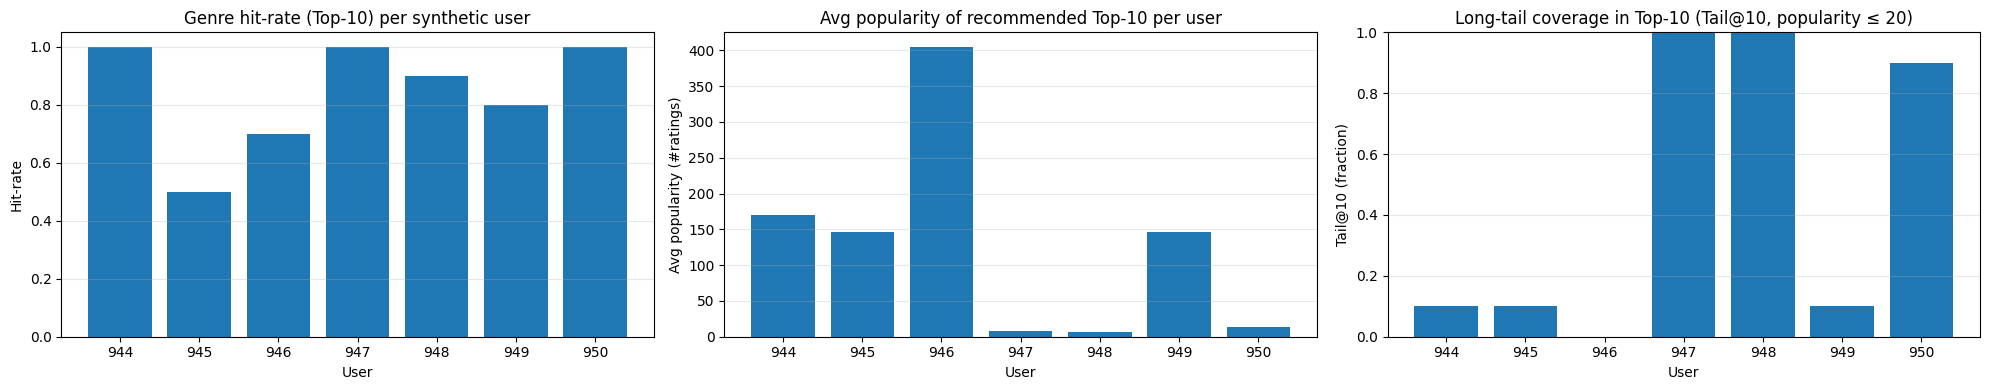

In [197]:
# --- Compute Tail@10 (share of Top-10 that belongs to the long tail) ---
# Define "long tail" as items with popularity <= threshold
TAIL_THRESHOLD = 20  # adjust if you want (e.g., 30, 50, or a percentile)

items_m = items_meta.set_index("item_id")

def tail_share_at_10(user_id):
    # recs[user_id] must be your Top-10 dataframe with column "item_id"
    pops = items_m.loc[recs[user_id]["item_id"], "popularity"].to_numpy()
    return (pops <= TAIL_THRESHOLD).mean()

eval_df = eval_df.copy()
eval_df["tail_at_10"] = eval_df["user_id"].apply(tail_share_at_10)

# --- Plot 3 charts in a single row ---
fig, axes = plt.subplots(1, 3, figsize=(20, 4))

# 1) Genre hit-rate per user
axes[0].bar(eval_df["user_id"].astype(str), eval_df["hit_rate_genres"])
axes[0].set_title("Genre hit-rate (Top-10) per synthetic user")
axes[0].set_xlabel("User")
axes[0].set_ylabel("Hit-rate")
axes[0].grid(axis="y", alpha=0.3)

# 2) Average popularity of the Top-10 per user
axes[1].bar(eval_df["user_id"].astype(str), eval_df["avg_popularity_top10"])
axes[1].set_title("Avg popularity of recommended Top-10 per user")
axes[1].set_xlabel("User")
axes[1].set_ylabel("Avg popularity (#ratings)")
axes[1].grid(axis="y", alpha=0.3)

# 3) Tail@10 per user
axes[2].bar(eval_df["user_id"].astype(str), eval_df["tail_at_10"])
axes[2].set_title(f"Long-tail coverage in Top-10 (Tail@10, popularity ≤ {TAIL_THRESHOLD})")
axes[2].set_xlabel("User")
axes[2].set_ylabel("Tail@10 (fraction)")
axes[2].set_ylim(0, 1)
axes[2].grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()

#### ¿Que tan bien cree que el sistema esta respondiendo a los gustos del usuario?

In [198]:
# Confirm 946 Added Ratings Are Film-Noir
added_946 = added[added["user_id"]==946]
added_946["Film-Noir"].value_counts()
# Confirm TOP 10 for 946 has high Film-Noir presence
items_meta.set_index("item_id").loc[recs[946]["item_id"], "Film-Noir"].value_counts()

Film-Noir
0    10
Name: count, dtype: int64

En general, el sistema responde “bien” para perfiles amplios/mainstream, pero responde regular o mal para perfiles de nicho bien definidos, y además muestra un comportamiento inconsistente entre recomendar head vs. cola larga.

- Perfiles mainstream o con gustos amplios (944, 947, 948, 950): el hit-rate por géneros es alto (0.9–1.0). Sin embargo, en varios casos el conjunto de “géneros preferidos” es muy grande, lo que vuelve el hit-rate una métrica fácil de cumplir (casi cualquier recomendación comparte algún género). Aun así, sugiere que el modelo sí capta señales generales del gusto.

- Perfil nicho mixto (945) y horror/mixto (949): el hit-rate baja (0.5 y 0.8) y la popularidad promedio se mantiene alta (~146), lo que indica que el modelo tiende a refugiarse en ítems populares cuando el perfil es más específico o hay menos evidencia.

- Perfil nicho extremo (946 “Film-Noir only”): aunque el hit-rate general es 0.7, el indicador clave es que film_noir_hit_rate = 0.0: ninguna de las 10 recomendaciones es Film-Noir y además la popularidad promedio es muy alta (~405). Esto muestra que el sistema no está capturando el nicho objetivo y presenta un sesgo fuerte hacia lo popular, recomendando géneros “cercanos” (Crime/Thriller/Mystery) pero no el género específico.

*Conclusión*: el sistema se comporta aceptablemente para gustos generales, pero no personaliza bien cuando el gusto es nicho (especialmente Film-Noir), y su exploración de cola larga no es estable. Esto sugiere sesgo de popularidad y falta de señal/regularización en el enfoque KNN item–item con coseno.

#### ¿Que tan bien cree que el sistema esta respondiendo al objetivo de buscar items para el usuario dentro de la cola larga?

La evidencia dice que el sistema no cumple consistentemente el objetivo de recomendar en cola larga: para algunos usuarios (947, 948, 950) sí explora cola larga (popularidad promedio Top-10 ≈ 6–13), pero para otros (946 y también 944/945/949) se va al head (popularidad promedio ≈ 146–405). O sea: la exploración de long tail depende mucho del perfil y no es estable.

# 3. Otros frameworks para filtrado colaborativo

Revise alguno de los siguientes frameworks, verifique su
documentación e indique de manera simple cómo se crearía en este un sistema de recomendación similar al
implementado en este laboratorio.

In [199]:
# Install
!pip -q install lenskit
import lenskit
print("LensKit version:", lenskit.__version__)


[notice] A new release of pip is available: 24.3.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
LensKit version: 2025.6.3


In [200]:
# Imports + split
from sklearn.model_selection import train_test_split

from lenskit.data import from_interactions_df
from lenskit.pipeline import topn_pipeline
from lenskit import predict

from lenskit.knn.item import ItemKNNScorer
from lenskit.knn.user import UserKNNScorer

# Same idea as Surprise: 80/20 split
train_df, test_df = train_test_split(
    ratings[["user_id", "item_id", "rating"]],
    test_size=0.2,
    random_state=42
)

# Build LensKit dataset FROM TRAIN ONLY
train_lk = from_interactions_df(
    train_df,
    user_col="user_id",
    item_col="item_id",
    rating_col="rating"
)

In [201]:
# Helper to evaluate RMSE/MAE (rating prediction)
def eval_rmse_mae(pipe, test_df: pd.DataFrame):
    # Predict test items user-by-user (faster and cleaner than predicting row-by-row)
    pred_frames = []
    for uid, grp in test_df.groupby("user_id"):
        il = predict(pipe, uid, grp["item_id"].tolist())
        pdf = il.to_df()[["item_id", "score"]].rename(columns={"score": "est"})
        pdf["user_id"] = uid
        pred_frames.append(pdf)

    pred_df = pd.concat(pred_frames, ignore_index=True)
    joined = test_df.merge(pred_df, on=["user_id", "item_id"], how="left")

    rmse = np.sqrt(((joined["rating"] - joined["est"]) ** 2).mean())
    mae  = (joined["rating"] - joined["est"]).abs().mean()

    return rmse, mae, joined

In [202]:
# Item-Item kNN scorer
scorer_ii = ItemKNNScorer(
    max_nbrs=20,   # like k=20
    min_nbrs=2,    # like min_k=2
    feedback="explicit"
)

# Pipeline that can predict ratings (includes a bias fallback)
pipe_ii = topn_pipeline(scorer_ii, predicts_ratings=True)
pipe_ii.train(train_lk)

# Example prediction (similar to algo.predict(154, 302))
example = predict(pipe_ii, 154, [302]).to_df()
example


,item_id,score,nbr_counts
0,302,3.981495,20


In [203]:
rmse_ii_lenskit, mae_ii, joined_ii = eval_rmse_mae(pipe_ii, test_df)
print(f"Item-Item | RMSE={rmse_ii_lenskit:.4f} | MAE={mae_ii:.4f}")

Item-Item | RMSE=0.9157 | MAE=0.7157


In [204]:
# User-User kNN scorer
scorer_uu = UserKNNScorer(
    max_nbrs=20,
    min_nbrs=2,
    feedback="explicit"
)

pipe_uu = topn_pipeline(scorer_uu, predicts_ratings=True)
pipe_uu.train(train_lk)

rmse_uu_lenskit, mae_uu, joined_uu = eval_rmse_mae(pipe_uu, test_df)
print(f"User-User | RMSE={rmse_uu_lenskit:.4f} | MAE={mae_uu:.4f}")


User-User | RMSE=0.9405 | MAE=0.7337


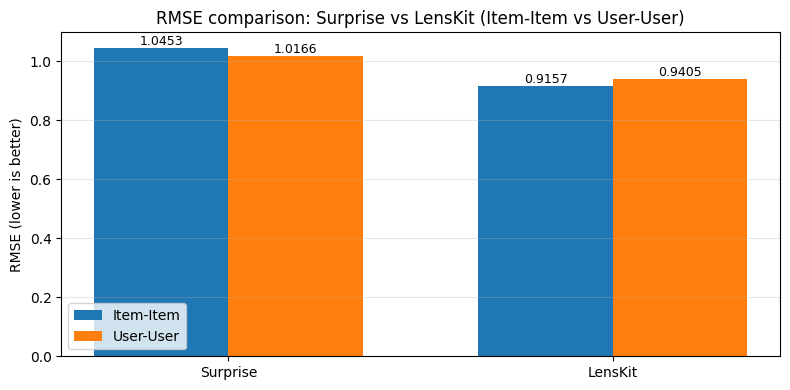

,Framework,Model,RMSE
0,Surprise,Item-Item,1.045334
1,Surprise,User-User,1.016641
2,LensKit,Item-Item,0.915687
3,LensKit,User-User,0.940462


In [205]:
# Surprise, Lenskit Comparison
rmse_surprise_item = rmse_ii_surprise
rmse_surprise_user = rmse_uu_surprise
rmse_lenskit_item  = rmse_ii_lenskit
rmse_lenskit_user  = rmse_uu_lenskit

df = pd.DataFrame({
    "Framework": ["Surprise", "Surprise", "LensKit", "LensKit"],
    "Model":     ["Item-Item", "User-User", "Item-Item", "User-User"],
    "RMSE":      [rmse_surprise_item, rmse_surprise_user, rmse_lenskit_item, rmse_lenskit_user]
})

# --- Grouped bar chart ---
frameworks = ["Surprise", "LensKit"]
models = ["Item-Item", "User-User"]

x = np.arange(len(frameworks))  # positions for frameworks
w = 0.35                        # bar width

rmse_item = [df[(df.Framework==f) & (df.Model=="Item-Item")]["RMSE"].values[0] for f in frameworks]
rmse_user = [df[(df.Framework==f) & (df.Model=="User-User")]["RMSE"].values[0] for f in frameworks]

fig, ax = plt.subplots(figsize=(8, 4))
b1 = ax.bar(x - w/2, rmse_item, width=w, label="Item-Item")
b2 = ax.bar(x + w/2, rmse_user, width=w, label="User-User")

ax.set_xticks(x)
ax.set_xticklabels(frameworks)
ax.set_ylabel("RMSE (lower is better)")
ax.set_title("RMSE comparison: Surprise vs LensKit (Item-Item vs User-User)")
ax.grid(axis="y", alpha=0.3)
ax.legend()

# value labels
for bars in (b1, b2):
    for bar in bars:
        h = bar.get_height()
        ax.annotate(f"{h:.4f}",
                    (bar.get_x() + bar.get_width()/2, h),
                    ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.show()

df